## Change Language Parameter

In [1]:
lang = "en" #set language to language of interest [en, it, ru]

## Web Scraping

In [2]:
# import relevant packages
import wikipedia
import pandas as pd
import warnings
import numpy as np
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import spacy
import tqdm
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()# Visualise inside a notebook
import en_core_web_md
import gensim
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaMulticore
from gensim.models import LdaModel
from gensim.models import CoherenceModel

/Users/bhaveshchainani/virtualenv/testing_2/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/bhaveshchainani/virtualenv/testing_2/lib/python3.8/site-packages/gensim/matutils.py:22: DeprecationWarning: Please use `triu` from the `scipy.linalg` namespace, the `scipy.linalg.special_matrices` namespace is deprecated.
  from scipy.linalg.special_matrices import triu


In [3]:
#selective wikipedia article topics
articles = ['George_Clooney', 'Shah_Rukh_Khan', 'Leonardo_DiCaprio', 'Will_Smith',
            'Kamal_Haasan', 'Tom_Cruise', 'Dwayne_Johnson', 'Brad_Pitt',
            'Johnny_Depp', 'Morgan_Freeman', 'Ed_Sheeran', 'A._R._Rahman',
            'Bruno_Mars', 'Taylor_Swift', 'Eminem', 'Shakira', 'Ellie_Goulding',
            'Michael_Jackson', 'Selena_Gomez', 'Lionel_Messi',
            'Cristiano_Ronaldo', 'Rafael_Nadal', 'Usain_Bolt',
            'Stephen_Curry', 'Roger_Federer', 'Virat_Kohli', 'Serena_Williams',
            'James_Patterson', 'Stephen_King', 'J._K._Rowling',
            'Dan_Brown', 'Agatha_Christie', 'Ken_Follett', 'Neil_Gaiman', 
            'John_Grisham', 'Nora_Roberts', 'Arundhati_Roy', 'Mark_Zuckerberg',
            'Jeff_Bezos', 'Bill_Gates', 'Larry_Page', 'Tim_Cook', 
            'Elon_Musk', 'Warren_Buffett', 'Xi_Jinping', 'Vladimir_Putin', 
            'Donald_Trump', 'Barack_Obama', 'David_Cameron', 'Hillary_Clinton',
            'Bill_Clinton']

In [4]:
print("Obtaining English data now")
wikipedia.set_lang("en")
content = []
person = []

for i in articles:
#     print("Examining " + str(i))
    person.append(wikipedia.page(i, auto_suggest=False).title)
    content.append(wikipedia.page(i, auto_suggest=False).content)
    
df_eng = pd.DataFrame(list(zip(person,content)), columns=['person', 'content'])
print("English dataframe has been created")

Obtaining English data now
English dataframe has been created


In [5]:
warnings.filterwarnings('ignore')
print("Obtaining Russian data now")
wikipedia.set_lang("ru")
content = []
person = []

for i in articles:
#     print("Examining " + str(i))
    person.append(wikipedia.page(i, auto_suggest=False).title)
    content.append(wikipedia.page(i, auto_suggest=False).content)
    
df_ru = pd.DataFrame(list(zip(person,content)), columns=['person', 'content'])
print("Russian dataframe has been created")

Obtaining Russian data now
Russian dataframe has been created


In [6]:
print("Obtaining Italian data now")
wikipedia.set_lang("it")
content = []
person = []

for i in articles:
#     print("Examining " + str(i))
    person.append(wikipedia.page(i, auto_suggest=False).title)
    content.append(wikipedia.page(i, auto_suggest=False).content)
    
df_it = pd.DataFrame(list(zip(person,content)), columns=['person', 'content'])
print("Italian dataframe has been created")

Obtaining Italian data now
Italian dataframe has been created


In [7]:
## combining data into data_comb
df_comb = pd.concat([df_eng, df_it, df_ru], axis=0).reset_index(drop=True)

df_comb.to_excel("../files/input/combined_data.xlsx",index=False)
print("Combined dataframe has been saved in ./files/input folder.")

Combined dataframe has been saved in ./files/input folder.


## Topic Modelling

In [8]:
## reading in combined data (obtained from wikipedia_scraping.py)
df_comb = pd.read_excel("../files/input/combined_data.xlsx")

In [9]:
df_comb.head()

,person,content
0,George Clooney,"George Timothy Clooney (born May 6, 1961) is a..."
1,Shah Rukh Khan,Shah Rukh Khan (pronounced [ˈʃɑːɦɾʊx xɑːn]; bo...
2,Leonardo DiCaprio,Leonardo Wilhelm DiCaprio (; Italian: [diˈkaːp...
3,Will Smith,"Willard Carroll Smith II (born September 25, ..."
4,Kamal Haasan,Kamal Haasan (born 7 November 1954) is an Indi...


In [10]:
## apply lang detect to content
from langdetect import detect, DetectorFactory
DetectorFactory.seed = 0

df_comb["actual_lang"] = df_comb["content"].apply(detect)

In [11]:
## filter data to required language
df = df_comb[df_comb["actual_lang"] == str(lang)].reset_index(drop=True)

In [12]:
## showcase filtered data
df.head()

,person,content,actual_lang
0,George Clooney,"George Timothy Clooney (born May 6, 1961) is a...",en
1,Shah Rukh Khan,Shah Rukh Khan (pronounced [ˈʃɑːɦɾʊx xɑːn]; bo...,en
2,Leonardo DiCaprio,Leonardo Wilhelm DiCaprio (; Italian: [diˈkaːp...,en
3,Will Smith,"Willard Carroll Smith II (born September 25, ...",en
4,Kamal Haasan,Kamal Haasan (born 7 November 1954) is an Indi...,en


In [13]:
## ignore warnings
warnings.filterwarnings('ignore')
lang_models = {"en": spacy.load("en_core_web_md"), "it": spacy.load("it_core_news_md"), "ru": spacy.load("ru_core_news_md")}

In [14]:
# Our spaCy model:
nlp = lang_models[str(lang)]
# Tags I want to remove from the text
removal= ['ADV','PRON','CCONJ','PUNCT','PART','DET','ADP','SPACE', 'NUM', 'SYM']
tokens = []
for summary in nlp.pipe(df['content']):
    proj_tok = [token.lemma_.lower() for token in summary if token.pos_ not in removal and not token.is_stop and token.is_alpha]
    tokens.append(proj_tok)

In [15]:
## append tokens to df and display subset of tokens
df['tokens'] = tokens
df['tokens'][:3]

0    [george, timothy, clooney, bear, american, act...
1    [shah, rukh, khan, pronounce, ˈʃɑːɦɾʊx, xɑːn, ...
2    [leonardo, wilhelm, dicaprio, italian, diˈkaːp...
Name: tokens, dtype: object

In [16]:
df.head()

,person,content,actual_lang,tokens
0,George Clooney,"George Timothy Clooney (born May 6, 1961) is a...",en,"[george, timothy, clooney, bear, american, act..."
1,Shah Rukh Khan,Shah Rukh Khan (pronounced [ˈʃɑːɦɾʊx xɑːn]; bo...,en,"[shah, rukh, khan, pronounce, ˈʃɑːɦɾʊx, xɑːn, ..."
2,Leonardo DiCaprio,Leonardo Wilhelm DiCaprio (; Italian: [diˈkaːp...,en,"[leonardo, wilhelm, dicaprio, italian, diˈkaːp..."
3,Will Smith,"Willard Carroll Smith II (born September 25, ...",en,"[willard, carroll, smith, ii, bear, september,..."
4,Kamal Haasan,Kamal Haasan (born 7 November 1954) is an Indi...,en,"[kamal, haasan, bear, november, indian, actor,..."


In [17]:
# I will apply the Dictionary Object from Gensim, which maps each word to their unique ID:
dictionary = Dictionary(df['tokens'])

In [18]:
print(dictionary.token2id)

{'abc': 0, 'abraham': 1, 'abramoff': 2, 'abrupt': 3, 'absence': 4, 'abuse': 5, 'academy': 6, 'accept': 7, 'acceptance': 8, 'accident': 9, 'acclaim': 10, 'accolade': 11, 'accord': 12, 'account': 13, 'accuse': 14, 'achievement': 15, 'act': 16, 'acting': 17, 'action': 18, 'activism': 19, 'activist': 20, 'activity': 21, 'actor': 22, 'actors': 23, 'actress': 24, 'ada': 25, 'adapt': 26, 'adaptation': 27, 'adaption': 28, 'additional': 29, 'adelia': 30, 'adopt': 31, 'adultery': 32, 'adventure': 33, 'advisor': 34, 'advocacy': 35, 'advocate': 36, 'affleck': 37, 'affordable': 38, 'afi': 39, 'age': 40, 'agency': 41, 'agent': 42, 'aid': 43, 'aim': 44, 'air': 45, 'al': 46, 'alamuddin': 47, 'alert': 48, 'alexander': 49, 'alfonso': 50, 'alive': 51, 'allen': 52, 'alliance': 53, 'allied': 54, 'altar': 55, 'amal': 56, 'amazon': 57, 'amc': 58, 'america': 59, 'american': 60, 'ancestry': 61, 'anchorman': 62, 'anderson': 63, 'andrei': 64, 'andrew': 65, 'andy': 66, 'angela': 67, 'angele': 68, 'angeles': 69, '

In [19]:
# filter dictionary
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=1000)

In [20]:
# create corpus
corpus = [dictionary.doc2bow(doc) for doc in df['tokens']]

In [21]:
print(corpus[:1])

[[(0, 1), (1, 1), (2, 4), (3, 1), (4, 1), (5, 1), (6, 2), (7, 1), (8, 1), (9, 19), (10, 5), (11, 1), (12, 3), (13, 2), (14, 1), (15, 2), (16, 2), (17, 2), (18, 1), (19, 2), (20, 3), (21, 3), (22, 1), (23, 1), (24, 1), (25, 2), (26, 1), (27, 2), (28, 2), (29, 2), (30, 3), (31, 4), (32, 1), (33, 1), (34, 2), (35, 1), (36, 1), (37, 1), (38, 1), (39, 8), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 3), (50, 1), (51, 1), (52, 5), (53, 1), (54, 2), (55, 7), (56, 4), (57, 2), (58, 1), (59, 1), (60, 1), (61, 3), (62, 1), (63, 3), (64, 1), (65, 2), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 2), (76, 2), (77, 1), (78, 2), (79, 1), (80, 1), (81, 1), (82, 1), (83, 18), (84, 2), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1), (90, 2), (91, 4), (92, 2), (93, 1), (94, 1), (95, 2), (96, 1), (97, 2), (98, 2), (99, 1), (100, 2), (101, 1), (102, 2), (103, 1), (104, 4), (105, 1), (106, 1), (107, 6), (108, 1), (109, 1), (110, 

In [22]:
# set baseline model
lda_model = LdaMulticore(corpus=corpus,
                       id2word=dictionary,
                       num_topics=10, 
                       random_state=100,
                       iterations=100,
                       chunksize=100,
                       passes=10,
                       per_word_topics=True)

In [23]:
# Print the Keyword in the 10 topics
from pprint import pprint
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.067*"king" + 0.045*"rock" + 0.028*"novel" + 0.019*"publish" + '
  '0.015*"match" + 0.013*"championship" + 0.012*"character" + 0.011*"episode" '
  '+ 0.008*"football" + 0.007*"read"'),
 (1,
  '0.072*"india" + 0.046*"page" + 0.035*"indian" + 0.027*"score" + '
  '0.023*"match" + 0.021*"test" + 0.012*"romance" + 0.011*"ceo" + '
  '0.010*"average" + 0.009*"century"'),
 (2,
  '0.089*"defeat" + 0.057*"match" + 0.056*"grand" + 0.038*"french" + '
  '0.031*"court" + 0.026*"ranking" + 0.026*"round" + 0.025*"season" + '
  '0.022*"double" + 0.019*"era"'),
 (3,
  '0.061*"clinton" + 0.033*"obama" + 0.024*"law" + 0.021*"election" + '
  '0.015*"presidential" + 0.011*"bill" + 0.010*"political" + 0.009*"health" + '
  '0.009*"vote" + 0.009*"hillary"'),
 (4,
  '0.061*"season" + 0.058*"player" + 0.057*"score" + 0.053*"goal" + '
  '0.050*"match" + 0.035*"league" + 0.021*"defeat" + 0.021*"finish" + '
  '0.020*"cup" + 0.016*"injury"'),
 (5,
  '0.074*"album" + 0.045*"song" + 0.042*"music" + 0.024*"art

In [24]:
# Compute Perplexity of Baseline model
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score of Baseline model
coherence_model_lda = CoherenceModel(model=lda_model, texts=df['tokens'], dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.275226177274757

Coherence Score:  0.6319865601109529


## Hyperparameter Tuning (Topic Number)

Running iteration number 1
Running iteration number 2
Running iteration number 3
Running iteration number 4
Running iteration number 5
Running iteration number 6
Running iteration number 7
Running iteration number 8
Running iteration number 9


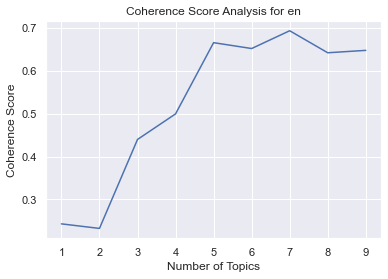

In [25]:
# run iteration for coherence score for each topic number

topics = []
score = []
for i in range(1,10,1):
    print("Running iteration number " + str(i))
    lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=100, num_topics=i, workers = 4, passes=10, random_state=100, chunksize=100)
    cm = CoherenceModel(model=lda_model, texts = df['tokens'], corpus=corpus, dictionary=dictionary, coherence='c_v')
    topics.append(i)
    score.append(cm.get_coherence())
fig, ax = plt.subplots(nrows=1, ncols=1)
plt.plot(topics, score)
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title('Coherence Score Analysis for ' + str(lang))
fig.patch.set_facecolor('white')
plt.show()
#fig.savefig("../files/output/" + str(lang) + "/coherence_score_" + str(lang) + ".png", bbox_inches='tight')

## Further Hyperparameter Tuning

In [26]:
#supporting function

def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=df['tokens'], dictionary=dictionary, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

#### The code below will take a long time to run (~1 hour). The results have been saved in "../files/output/[lang]" folder, where [lang] is our language parameter.

In [27]:
## code to iterate through different topic numbers, alpha and beta scores,
## to obtain the highest coherence score

grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)
# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')
# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')
# Validation sets
num_of_docs = len(corpus)
corpus_sets = [gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]
corpus_title = ['75% Corpus', '100% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }
# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=540)
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=dictionary, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)                
                    pbar.update(1)
#     pd.DataFrame(model_results).to_csv('lda_tuning_results_'+str(lang)+'.csv', index=False)
    pbar.close()

In [28]:
## best parameters for each language model (pre-run already)
## user can change parameter to his or her liking

topic_lang = {"en": 7, "it": 6, "ru": 8}
topic_alpha = {"en": "symmetric", "it": "asymmetric", "ru": "asymmetric"}
topic_beta = {"en": 0.01, "it": 0.91, "ru": 0.01}

In [29]:
## assigning parameters based on language parameter selected
num_topics = topic_lang[lang]
alpha = topic_alpha[lang]
beta = topic_beta[lang]

In [30]:
print("Number of topics with highest coherence score for " + str(lang) + " model is: " + str(num_topics))

Number of topics with highest coherence score for en model is: 7


In [31]:
## train model for respective language with best parameters
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=100, num_topics=num_topics, workers = 4, passes=100, alpha=alpha, eta=beta, random_state=100)

In [32]:
## print words present in each topic, along with their weights
lda_model.print_topics(-1)

[(0,
  '0.048*"novel" + 0.036*"king" + 0.023*"rock" + 0.021*"publish" + 0.019*"brown" + 0.013*"character" + 0.011*"fiction" + 0.009*"read" + 0.009*"cross" + 0.009*"writing"'),
 (1,
  '0.034*"india" + 0.023*"page" + 0.011*"ceo" + 0.011*"test" + 0.010*"indian" + 0.009*"computer" + 0.008*"worth" + 0.008*"energy" + 0.008*"purchase" + 0.007*"net"'),
 (2,
  '0.065*"defeat" + 0.063*"match" + 0.036*"grand" + 0.030*"championship" + 0.027*"season" + 0.026*"double" + 0.026*"round" + 0.025*"finish" + 0.022*"french" + 0.020*"player"'),
 (3,
  '0.029*"clinton" + 0.021*"party" + 0.018*"election" + 0.018*"obama" + 0.016*"law" + 0.011*"political" + 0.011*"presidential" + 0.010*"vote" + 0.009*"government" + 0.009*"policy"'),
 (4,
  '0.100*"score" + 0.065*"goal" + 0.065*"match" + 0.062*"season" + 0.056*"player" + 0.043*"league" + 0.016*"cup" + 0.016*"average" + 0.016*"competition" + 0.015*"assist"'),
 (5,
  '0.081*"album" + 0.051*"song" + 0.046*"music" + 0.027*"artist" + 0.022*"tour" + 0.020*"chart" + 0.

### Example of Model Prediction

In [33]:
df['content'][0][:500]

'George Timothy Clooney (born May 6, 1961) is an American actor and filmmaker. He is the recipient of numerous accolades, including a British Academy Film Award, four Golden Globe Awards, four Screen Actors Guild Awards, and two Academy Awards, one for his acting and the other as a producer. In 2018, he was the recipient of the AFI Life Achievement Award.Clooney started his career in television, gaining wide recognition in his role as Dr. Doug Ross on the NBC medical drama ER from 1994 to 1999, f'

In [34]:
lda_model[corpus][0]

[(0, 0.18099368), (3, 0.19512619), (6, 0.61121374)]

### Visualisation

In [35]:
# set sort_topics to be False to ensure same order as gensim model
# thing to take note of is that gensim starts from 0, pyldavis starts from 1

lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)
#pyLDAvis.save_html(lda_display, "../files/output/" + str(lang) + "/lda_" + str(lang) + ".html")

### Assign main topic number to each row

In [36]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=df['tokens']):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
#     contents = pd.Series(texts)
#     sent_topics_df = pd.concat([sent_topics_df, df], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=df['tokens'])

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index(drop=True)
df_dominant_topic.columns = ['Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords']
df_dominant_topic = pd.concat([df,df_dominant_topic], axis=1)

In [37]:
df_dominant_topic = df_dominant_topic.sort_values(by='Topic_Perc_Contrib',ascending=False).reset_index(drop=True)

In [38]:
## showcase final dataframe snippet
df_dominant_topic.head()

,person,content,actual_lang,tokens,Dominant_Topic,Topic_Perc_Contrib,Keywords
0,Bill Clinton,William Jefferson Clinton (né Blythe III; born...,en,"[william, jefferson, clinton, né, blythe, iii,...",3,0.9991,"clinton, party, election, obama, law, politica..."
1,Hillary Clinton,Hillary Diane Clinton (née Rodham; born Octobe...,en,"[hillary, diane, clinton, née, rodham, bear, o...",3,0.9991,"clinton, party, election, obama, law, politica..."
2,Bruno Mars,"Peter Gene Hernandez (born October 8, 1985), k...",en,"[peter, gene, hernandez, bear, october, know, ...",5,0.9991,"album, song, music, artist, tour, chart, award..."
3,Ed Sheeran,Edward Christopher Sheeran (; born 17 Februar...,en,"[edward, christopher, sheeran, bear, february,...",5,0.9990,"album, song, music, artist, tour, chart, award..."
4,Larry Page,"Lawrence Edward Page (born March 26, 1973) is ...",en,"[lawrence, edward, page, bear, march, american...",1,0.9990,"india, page, ceo, test, indian, computer, wort..."


In [39]:
## save dataframe as excel file
writer = pd.ExcelWriter('../files/output/' +str(lang) + '/topic_modelling_output_' + str(lang) + '.xlsx' , engine='xlsxwriter')
workbook = writer.book
workbook.formats[0].set_font_size(12)
df_dominant_topic.to_excel(writer, sheet_name = 'Output', index=False)

for idx, col in enumerate(df_dominant_topic):  # loop through all columns
    series = df_dominant_topic[col]
    max_len = 20
    writer.sheets['Output'].set_column(idx, idx, max_len)  # set column width
    
writer.close()